# Ada Final Project - EDA

In [421]:
# Python Standard Libraries
import re
import csv
import bz2
import json
import string

# Install using conda
# conda install matplotlib pandas ipywidgets beautifulsoup4 nltk
import nltk
#import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup


# Not available through Conda
#!pip  install syllables transformers

#import syllables

# BERT related modules
#from transformers import BertTokenizer, BertModel


%matplotlib inline

nltk.download([
     "names",
     "stopwords",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ]);

[nltk_data] Downloading package names to
[nltk_data]     /Users/leonardkarsunky/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardkarsunky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leonardkarsunky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leonardkarsunky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leonardkarsunky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [423]:
PATH_TO_FILE = 'data/hillary-and-trump-quotes-2016.json.bz2'

CEFR_HTML_IN = "data/cefr_data.html"

CEFR_CLEAN_CSV_IN = "data/cefr_data_clean.csv"
CEFR_CSV_OUT = "data/cefr_data.csv"

CHUNK_SIZE = 100_000

RANDOM_SAMPLE_SIZE = 30_000

SEED = 92813

## 1. Load Data

### Initial Data Extraction

For reference we include the code we executed on Google Colab to extract all quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016** from the Quotebank dataset. This was a one time operation, which is why we did it outside of this notebook. All other algorithms we apply to the data will be/have been possibly iterated on for improvement, which is where the notebook format comes in handy.

```python
PATH_TO_FILE = '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2'
PATH_TO_OUT = '/content/drive/MyDrive/hillary-and-trump-quotes-2016.json.bz2'

SPEAKER_NAMES = ['Hillary Clinton', 'Donald Trump']

hits = 0

with bz2.open(PATH_TO_FILE, 'rb') as s_file:
    with bz2.open(PATH_TO_OUT, 'wb') as d_file:

        for instance in s_file:

            instance = json.loads(instance)
            speaker = instance['speaker']

            if any(map(speaker.__contains__, desired_speakers)):

                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

                hits += 1


print(f"Hits: {hits}")
```

In [424]:
df_1 = pd.read_json(PATH_TO_FILE, lines=True, compression='bz2') #chunksize=CHUNK_SIZE)

## 2. Enhance Data

In [425]:
df_2 = df_1

df_2['proba'] = df_2['probas'].apply(lambda probas : float(probas[0][1]))

df_2.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,0.9025
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E,0.7921
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E,0.8488
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E,0.6887
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E,0.9679


## Samples

In [426]:
sample = df_2.sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

dt_sample = df_2[df_2['speaker'] == 'Donald Trump'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)
hc_sample = df_2[df_2['speaker'] == 'Hillary Clinton'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

## 3. Clean Data

In [427]:
df_3 = df_2

We are only interested in quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016**, specifically from 01/01/2016 - 01/01/2017. The subset loaded only contains the Quotebank quotes which have one (or both) of them as a possible speaker in the _speaker_ columns list and that lie in the specified time frame.

Since the dataset was obtained using a ML model to extract and assign the quotes there will most likely be quotes which are faulty and quotes which have been assigned to the wrong speaker. The goal of the data cleaning is to remove such data points so that we can focus on working with as good data as possible.

We must specify what makes a quote faulty and motivate this so that we remove as many bad quotes as possible while not removing any or as little actually correct quotes as possible.

### 3.1 Filter: Remove quotes with low probas

**Motivation**

Certain quotes that the model assigned to Trump and Clinton have very low probabilities to actually be quotes by them inside of the text as by the computation of the model. We want to learn about the distribution of the probability of the assigned quotes so that we can take a decision on if and when to filter out certain quotes due to a too low probability computed for them by the model.

**Distribution of the Proba**

Here we plot the distribution of a sample of 1,000 Trump and 1,000 Clinton quotes respectively. The reason we sample seperatley is given the fact that we want to ensure a large enough sample pool for both candidates, which is needed since there are more quotes assigned to Trump than Clinton. We also plot the two seperatly to make sure that we do not miss any differences in the dsitribution.

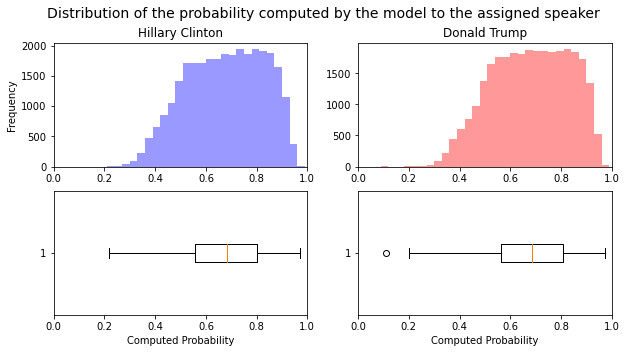

Hillary Clinton Summary Statistics


count    30000.000000
mean         0.675683
std          0.150956
min          0.216200
25%          0.557100
50%          0.683800
75%          0.802225
max          0.969500
Name: proba, dtype: float64


Donald Trump Summary Statistics


count    30000.000000
mean         0.675683
std          0.150956
min          0.216200
25%          0.557100
50%          0.683800
75%          0.802225
max          0.969500
Name: proba, dtype: float64

<Figure size 432x288 with 0 Axes>

In [428]:
n_bins = 40
proba_bins = [round((1 / n_bins), 2) * i for i in range(0, n_bins  + 1)]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Distribution of the probability computed by the model to the assigned speaker", fontsize=14)

axs[0, 0].set(xlim=(0, 1))
axs[0, 1].set(xlim=(0, 1))

axs[0, 0].hist(hc_sample['proba'], bins=proba_bins, color='b', alpha=0.4)
axs[0, 1].hist(dt_sample['proba'], bins=proba_bins, color='r', alpha=0.4)

axs[1, 0].set(xlim=(0, 1))
axs[1, 1].set(xlim=(0, 1))

axs[1, 0].boxplot(hc_sample['proba'], vert=False)
axs[1, 1].boxplot(dt_sample['proba'], vert=False)


axs[0, 0].set_ylabel('Frequency')
axs[0, 0].title.set_text('Hillary Clinton')

axs[0, 1].title.set_text('Donald Trump')

axs[1, 1].set_xlabel('Computed Probability')
axs[1, 0].set_xlabel('Computed Probability')

plt.show()
plt.clf()

print("Hillary Clinton Summary Statistics")
display(hc_sample['proba'].describe())
print()
print("Donald Trump Summary Statistics")
display(hc_sample['proba'].describe())

From plotting the distribution of probabilities which the model computed to the quotes it assigned to Trump and Hillary respectively we could now act in at least 3 ways:

1. Remove any quote which is below the min probability minus a small margin because they are outliers. **I.e. Only Remove outliers.**

2. Set the cutoff even higher because we decide to consider quotes with, ex. less than 0.4 probability assigned to the candidate being the speaker too weak to consider it in further analysis.

3. A further possibility could be to remove quotes, where the next best speaker assigned has a similair/close probability compare to the number one.
   
   Example: `[ [ 'Trump', 0.41 ], [ 'Kanye West', 0.39 ], ...]`

**TODO for later:** What should we do? What is scientifically sound? How do we motivate it?



**Filtering out datapoints with too low probability**

In [429]:
PROBAS_THRESHOLD = 0.5

In [430]:
df_3_1 = df_3

df_3_1 = df_3_1[df_3_1['proba'] >= PROBAS_THRESHOLD]

n_removed_lines = len(df_3) - len(df_3_1)
percentage_removed = (n_removed_lines / len(df_1)) * 100

print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset".format(n_removed_lines, percentage_removed))

Removed 20,124 datapoints or 13.96% of the original dataset


### 3.2 Remove quotes by different Speakers

In [431]:
df_3_1.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

speaker
Donald Trump              88712
Hillary Clinton           34236
President Donald Trump      613
Donald Trump Jr. .          308
president Donald Trump       60
Donald Trump , Jr. .         42
Donald Trump Jr              32
Name: quotation, dtype: int64

In [432]:
df_3_2 = df_3_1

df_3_2 = df_3_2[df_3_2['speaker'].isin(['Hillary Clinton', 'Donald Trump'])]

display(df_3_2.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation'])


n_removed_lines = len(df_3_1) - len(df_3_2)
percentage_removed = (n_removed_lines / len(df_1)) * 100

print("\n")

print("Removed {:,.0f} datapoints or {:,.2f}% of the original dataset".format(n_removed_lines, percentage_removed))

speaker
Donald Trump       88712
Hillary Clinton    34236
Name: quotation, dtype: int64



Removed 1,055 datapoints or 0.73% of the original dataset


### 3.3 Filter: Remove Quotes with "nonsense" content

**TODO**: We should ideally check for the quality of the quotes. There are certainly some faulty quotes and maybe even gibberish in the dataset but it is hopefully very limited in scope. We should nonetheless attempt to look for faulty/gibbersih quotes which were extracted by the model and remove them.

## 4. Data Analysis

### New sampling with the cleaned data

In [116]:
cleaned_sample = df_3_2.sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

dt_cleaned_sample = df_3_2[df_3_2['speaker'] == 'Donald Trump'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)
hc_cleaned_sample = df_3_2[df_3_2['speaker'] == 'Hillary Clinton'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

#### Patches for the Visualisations

In [117]:
blue_patch = mpatches.Patch(color='blue', alpha=0.4, label='Hillary Clinton')
red_patch = mpatches.Patch(color='red', alpha=0.4, label='Donald Trump')

### 4.1 General Exploration

NameError: name 'df_hc' is not defined

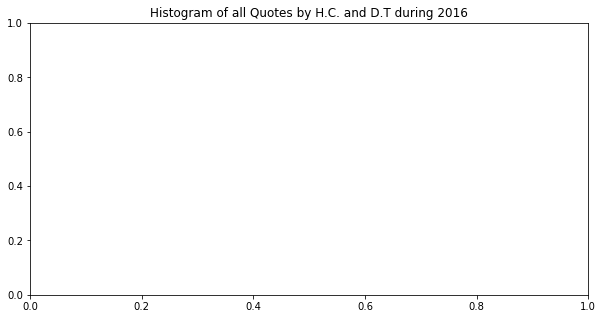

In [118]:
df_4_1 = df_3_2

n_bins = 52

plt.figure(figsize=(10,5))

plt.title("Histogram of all Quotes by H.C. and D.T during 2016")

df_4_1_hc = df_4_1[df_4_1['speaker'] == 'Hillary Clinton']
df_4_1_dt = df_4_1[df_4_1['speaker'] == 'Donald Trump']

plt.hist([df_hc['date'], df_dt['date']], weights=[df_hc['numOccurrences'], df_dt['numOccurrences']], bins=n_bins, color=["blue", "red"], alpha=0.4)

plt.legend(handles=[blue_patch, red_patch])

plt.show()
plt.clf()


**Questions arising**
- Why are there certain periods with barely any quotes?
- Is there something wrong/weird with the data?
- How can we test that everything is good?

## 5. Our Focus Questions

### Q1: Media Bias

Do media outlets portray Trump and Clinton differently? Do media outlets quote the two candidates equally much? Does the bias of the news outlet correlate with the quotes they report?

Let's take two of the biggest outlets with political leaning views, CNN and Breitbart, and compare the distribution of Trump quotes with Clinton quotes, and also see how positive or negative they are.

The NLTK library will also be used for sentiment analysis later on.

In [119]:
cleaned_sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

speaker
Donald Trump       734
Hillary Clinton    266
Name: quotation, dtype: int64

**TODO:** Remove the wrong speakers...

#### Using NLTK’s Pre-Trained Sentiment Analyzer

We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [120]:
sia = SentimentIntensityAnalyzer()

trump_polarity_scores = dt_cleaned_sample['quotation'].apply(sia.polarity_scores)
dt_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_cleaned_sample['quotation'].apply(sia.polarity_scores)
hc_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

<ipython-input-121-67ee2a91be75>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_cnn['polarityScore'] = [score.get('compound') for score in trump_cnn_PS]
<ipython-input-121-67ee2a91be75>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_cnn['polarityScore'] = [score.get('compound') for score in clinton_cnn_PS]


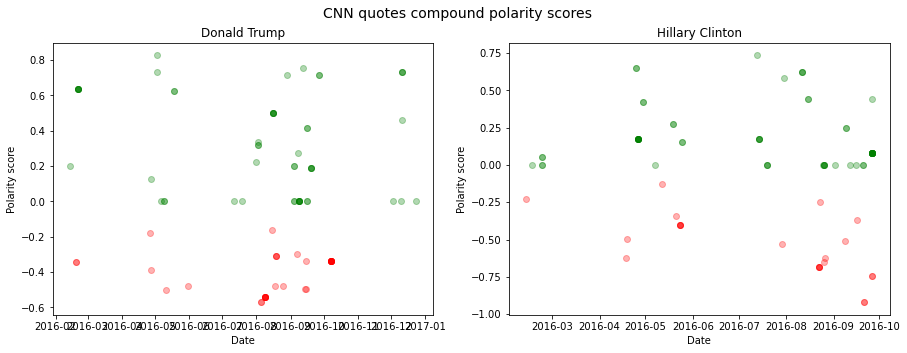

<Figure size 432x288 with 0 Axes>

In [121]:
trump_df = dt_cleaned_sample
clinton_df = hc_cleaned_sample

cnn_trump, cnn_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_trump.append(i)

trump_cnn = trump_df.iloc[cnn_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_clinton.append(i)

clinton_cnn = clinton_df.iloc[cnn_clinton]
        
trump_cnn_PS = trump_cnn['quotation'].apply(sia.polarity_scores)
trump_cnn['polarityScore'] = [score.get('compound') for score in trump_cnn_PS]
clinton_cnn_PS = clinton_cnn['quotation'].apply(sia.polarity_scores)
clinton_cnn['polarityScore'] = [score.get('compound') for score in clinton_cnn_PS]

trump_cnn_pos = trump_cnn[trump_cnn['polarityScore'] >= 0]
trump_cnn_neg = trump_cnn[trump_cnn['polarityScore'] < 0]
clinton_cnn_pos = clinton_cnn[clinton_cnn['polarityScore'] >= 0]
clinton_cnn_neg = clinton_cnn[clinton_cnn['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_cnn_pos['date'], y=trump_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_cnn_neg['date'], y=trump_cnn_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_cnn_pos['date'], y=clinton_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_cnn_neg['date'], y=clinton_cnn_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("CNN quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

<ipython-input-122-a4629c6868d3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_breitbart['polarityScore'] = [score.get('compound') for score in trump_breitbart_PS]
<ipython-input-122-a4629c6868d3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_breitbart['polarityScore'] = [score.get('compound') for score in clinton_breitbart_PS]


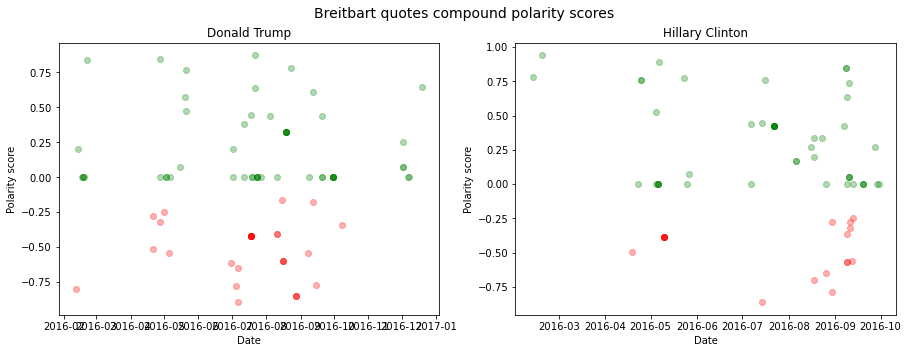

<Figure size 432x288 with 0 Axes>

In [122]:
breitbart_trump, breitbart_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_trump.append(i)

trump_breitbart = trump_df.iloc[breitbart_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_clinton.append(i)

clinton_breitbart = clinton_df.iloc[breitbart_clinton]
        
trump_breitbart_PS = trump_breitbart['quotation'].apply(sia.polarity_scores)
trump_breitbart['polarityScore'] = [score.get('compound') for score in trump_breitbart_PS]
clinton_breitbart_PS = clinton_breitbart['quotation'].apply(sia.polarity_scores)
clinton_breitbart['polarityScore'] = [score.get('compound') for score in clinton_breitbart_PS]

trump_breitbart_pos = trump_breitbart[trump_breitbart['polarityScore'] >= 0]
trump_breitbart_neg = trump_breitbart[trump_breitbart['polarityScore'] < 0]
clinton_breitbart_pos = clinton_breitbart[clinton_breitbart['polarityScore'] >= 0]
clinton_breitbart_neg = clinton_breitbart[clinton_breitbart['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_breitbart_pos['date'], y=trump_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_breitbart_neg['date'], y=trump_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_breitbart_pos['date'], y=clinton_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_breitbart_neg['date'], y=clinton_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("Breitbart quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

This might be a very small sample size for the EDA, but we can already see substantial bias both in terms of the number of quotes by a candidate in each media outlet as well as the ratio of positive/negative quotes chosen by the CNN and Breitbart to represent the two Presidential candidates. This most likely holds true for other popular media outlets, especially those with politically inclined views.

### Q2: Political Issues

We want to track the different political topics that the candidates focused on according to the content of their quotes. From this we aim to learn the importance of the topics in a absolut relative context but also in regards to when a certain topic might have been very present and then. disappeared for some time. We furthermore want to see if there might be a candidate which sparked a topic or at least started talking/being quoted about it first.

Bewlow we show an example of a topic in regards to Obamacare, which we all remember to be a important topic during the debate.

In [123]:
OBAMACARE_REGEX = '(obama care)|obamacare' # Not perfect, proof of concept...

df_obamacare = df_3_2[df_3_2['quotation'].str.contains(pat = OBAMACARE_REGEX, regex = True, flags=re.IGNORECASE)].sort_values('date')
df_obamacare['date'] = df_obamacare['date'].apply(lambda date : date.date())

df_obamacare_hc = df_obamacare[df_obamacare['speaker'] == 'Hillary Clinton']
df_obamacare_dt = df_obamacare[df_obamacare['speaker'] == 'Donald Trump']

<ipython-input-123-2383c2da8e1b>:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_obamacare = df_3_2[df_3_2['quotation'].str.contains(pat = OBAMACARE_REGEX, regex = True, flags=re.IGNORECASE)].sort_values('date')


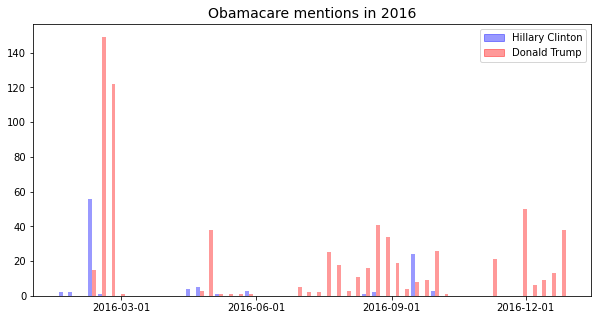

<Figure size 432x288 with 0 Axes>

In [124]:
BINS = 52
ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

plt.figure(figsize=(10,5))
plt.title("Obamacare mentions in 2016", fontsize=14)

plt.hist([df_obamacare_hc['date'], df_obamacare_dt['date']], weights=[df_obamacare_hc['numOccurrences'], df_obamacare_dt['numOccurrences']], bins=BINS, color=["b", "r"], alpha=0.4)

plt.xticks(ticks)
plt.legend(handles=[blue_patch, red_patch])

plt.show()
plt.clf()

In [125]:
def quote_topics_histogram(df_hc, df_dt, bins=52, topic_name=""):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    kwargs = {
        "alpha" : 0.4,
        "bins": bins,
    }

    axs[0].hist(df_hc['date'], weights=df_hc['numOccurrences'], color="b", **kwargs)
    axs[1].hist(df_dt['date'], weights=df_dt['numOccurrences'], color="r", **kwargs)

    fig.suptitle(f"Mentions of the Topic '{topic_name}' in 2016 by candidate", fontsize=16)

    axs[0].set_ylabel('Frequency')

    axs[0].title.set_text('Hillary Clinton')
    axs[0].set_xlabel('Date')

    axs[1].title.set_text('Donald Trump')
    axs[1].set_xlabel('Date')
    
    ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

    axs[0].set_xticks(ticks)
    axs[1].set_xticks(ticks)
    
    plt.show()
    plt.clf()

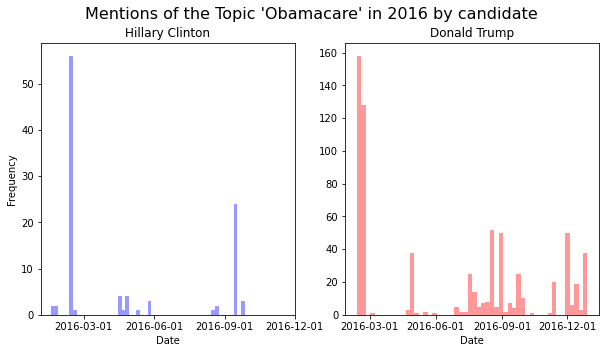

<Figure size 432x288 with 0 Axes>

In [126]:
# Example:
quote_topics_histogram(df_obamacare_hc, df_obamacare_dt, topic_name="Obamacare")

#### Important Interrlude

Hillary Clinton talked less about Obamacare but instead more about Healthcare... To be explored further!

### Visualisation Idea

We have identified several topics which show a clear periodic difference in occurance and intensity. We aim to visualise this data as illustrated in the sketch below for the final project. We hope to show how several topics come and go throughout the campaign and are focused on with a different amount of attention/importance depending on the candidate. Ideally we would extend this visualisation further allowing the viewer to see the importance the citizen base gave the topics at each time or the extent to which media reported on it. It would be amazing to see if some topics had a trendsetter who started talking about it earier adn fiercly...

We believe that our first EDA supports our thesis that the data will allow us to visualise it in this way, that there is peridoicity and hoepefully many interesting insights.

![Visualisation Sketch](focus-topics-sketch.jpg)

## Q3: Language

### a) Intellectuality of Language

Idea 1: Count the syllables in each candidate's consolidated quotes and compare distributions

In [127]:
def syllables_hist(dt_text: str, hc_text: str):

    dt_syl = list(map(syllables.estimate, dt_text.split()))
    hc_syl = list(map(syllables.estimate, hc_text.split()))

    kwargs = {
        "x"    : [hc_syl, dt_syl],
        "label" : ["Hillary Clinton", "Donald Trump"],
        "color" : ["b", "r"],
        "alpha" : 0.4,
        "bins" : range(1, 6),
        "density" : True,
        "align": "left",
    }

    plt.hist(**kwargs)
    plt.legend()
    plt.title("Histogram of number of syllables", fontsize=16)
    plt.xlabel("Number of syllables in a Word")
    plt.ylabel("Probability of Occuring")

    # TODO generalize this
    plt.xticks(range(1, 5), range(1, 5))

    plt.show()

In [128]:
hc_text = ' '.join(hc_cleaned_sample["quotation"])
dt_text = ' '.join(dt_cleaned_sample["quotation"])

In [129]:
syllables_hist(dt_text, hc_text)

NameError: name 'syllables' is not defined

Idea 2: Look at the CEFR language level. We can measure the language level for all words in each candidate's consolidated quotes and compare the distributions.

But first we need to get data on words. We have the HTML for a web page containing these data, and we can put them in the form of a CSV file.

In [130]:
def bs_to_csv(soup, csv_writer):
    table = soup.find("tbody")
    tr_rows = table.find_all("tr")
    csv_writer.writerow(["word", "guideword", "level", "part of speech", "topic"])
    csv_writer.writerows(
        [[t.text for t in r.find_all("td")][:-1] for r in tr_rows]
    )

In [131]:
# Scrape the HTML file and write in CSV format to file.
with open(CEFR_HTML_IN) as fp, open(CEFR_CSV_OUT, 'w') as csv_out:
    soup = BeautifulSoup(fp)
    csv_writer = csv.writer(csv_out, delimiter=',')
    bs_to_csv(soup, csv_writer)

FileNotFoundError: [Errno 2] No such file or directory: 'data/cefr_data.html'

In [132]:
df_cefr = pd.read_csv(CEFR_CSV_OUT)

display(df_cefr)

FileNotFoundError: [Errno 2] No such file or directory: 'data/cefr_data.csv'

The data includes idioms as well as nouns; this is intelligible for a human, but it might be a bit of trouble to make it work here, so we remove them.
We'll only need the `word` and `level` columns, so we remove the others as well.

In [133]:
df_cefr = df_cefr[[len(w.split()) == 1 for w in df_cefr["word"]]]\
                 .filter(items=["word", "level"])

NameError: name 'df_cefr' is not defined

Now we set everything to lowercase. Also it seems that some words have punctuation surrounding them, which is not desirable.

In [134]:
df_cefr["word"] = df_cefr["word"].transform(
    lambda w: w.lower()\
               .translate(str.maketrans('', '', string.punctuation)))

display(df_cefr.head())

NameError: name 'df_cefr' is not defined

Also, the same word can appear multiple times (as there might be different phrases in which the word means something slightly different) so we aggregate the levels using the median level.

In [135]:
cefr_level_map = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6,
}

In [136]:
df_cefr_copy = df_cefr.copy(deep=True)

NameError: name 'df_cefr' is not defined

In [137]:
# Use the map to transform the level column

df_cefr.level = df_cefr_copy["level"].map(cefr_level_map)

NameError: name 'df_cefr_copy' is not defined

In [138]:
# Aggregate with the median

df_cefr = df_cefr.groupby("word").agg("median").reset_index()

display(df_cefr.head())

NameError: name 'df_cefr' is not defined

Finally we change the index to the word itself to facilitate searching.

In [139]:
df_cefr.index = df_cefr.word
df_cefr = df_cefr.filter(items=["level"])

NameError: name 'df_cefr' is not defined

Now we can finally apply this to our dataset.

In [140]:
cefr_data = pd.read_csv(CEFR_CLEAN_CSV_IN, index_col="word")
cefr_data.loc["he"].loc["level"]

FileNotFoundError: [Errno 2] No such file or directory: 'data/cefr_data_clean.csv'

In [141]:
def cefr_level_hist(dt_text: str, hc_text: str):

    cefr_data = pd.read_csv(CEFR_CLEAN_CSV_IN, index_col="word")
    cefr_data.loc["he"].loc["level"]
    
    level = lambda w: cefr_data.loc[w].loc["level"] if w in cefr_data.index else 0

    dt_level = list(map(level, dt_text.split()))
    hc_level = list(map(level, hc_text.split()))

    kwargs = {
        "x"    : [hc_level, dt_level],
        "label" : ["Hillary Clinton", "Donald Trump"],
        "color" : ["b", "r"],
        "alpha" : 0.4,
        "bins" : range(0, 7),
        "density" : True,
        "align": "left",
    }
    plt.hist(**kwargs)
    plt.legend()
    plt.title("Histogram of English level of words", fontsize=16)
    plt.xlabel("English level")
    plt.ylabel("Probability")

    plt.xticks(range(0, 7), ["NA", "A1", "A2", "B1", "B2", "C1", "C2"])

    plt.show()

In [142]:
cefr_level_hist(dt_text.lower(), hc_text.lower())

FileNotFoundError: [Errno 2] No such file or directory: 'data/cefr_data_clean.csv'

There seems to be little difference in terms of language levels, but note how many words were not accounted for; this is due in part to limitations of our CEFR dataset, and also to the fact that some words appear in text in different forms (e.g. a verb conjugated to the past tense). This particular issue will be remedied by "stemming" the words to reduce them to their "base" form.

### Ideas

- Who is are Trump and Clinton most confused with? Using the other speaker attributions in the quotas list.

### b) Sentiment Analysis

In [433]:
cleaned_sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

speaker
Donald Trump       734
Hillary Clinton    266
Name: quotation, dtype: int64

##### Using NLTK’s Pre-Trained Sentiment Analyzer
We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [434]:
sia = SentimentIntensityAnalyzer()

In [435]:
trump_polarity_scores = dt_cleaned_sample['quotation'].apply(sia.polarity_scores)
dt_cleaned_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_cleaned_sample['quotation'].apply(sia.polarity_scores)
hc_cleaned_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

#### Donald Trump's 5 most positive and negative quotes

In [441]:
print("Trump's 5 most positive quotes:")
# trump_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("\n[+]", quote) for quote in dt_cleaned_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("\n---\n")

print("Trump's 5 most negative quotes:")
# trump_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("\n[-]", quote) for quote in dt_cleaned_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


Trump's 5 most positive quotes:

[+] I have a plan. But I want to be-I don't want to-look, I have a very substantial chance of winning. Make America great again. We're going to make America great again. I have a substantial chance of winning... if I like maybe a combination of my plan and the generals' plan, or the general's plan, if I like their plan, Matt, I'm not going to call you up and say, `Matt we have a great plan. '

[+] Well, they'll probably be different generals, to be honest with you... I have great faith in the military. I have great faith in certain of the commanders, certainly. But I have no faith in Hillary Clinton or the leadership,

[+] It is a great honor, a great, great honor, to be invited to Mexico, thank you Mr. President

[+] I'm going to make sure that people are making much more money because we're going to bring so many jobs back that we're not going to have to be worrying about minimum wage so much. We're going to be bringing the jobs back where people can 

[None, None, None, None, None]

#### Hillary Clinton's 5 most positive and negative quotes

In [442]:
print("Hillary Clinton's 5 most positive quotes:")
# clinton_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("\n[+]", quote) for quote in hc_cleaned_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("\n---\n")

print("Hillary Clinton's 5 most negative quotes:")
# clinton_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("\n[-]", quote) for quote in hc_cleaned_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


Hillary Clinton's 5 most positive quotes:

[+] Rural America is a leader in energy production -- helping to reduce our dependence on foreign oil and make our economy more resilient. Renewable fuels can also play an important role in reducing carbon pollution. Rural innovators are finding new ways to produce low-carbon biofuels, using feedstocks ranging from algae to agricultural waste, with a wide range of transportation applications. And electricity generated from wind and solar energy can improve air quality, help achieve attainment of Clean Air Act standards, and lower taxpayers' pollution control costs. America's farm communities are already playing a critical role in renewable energy production. For example, 99 percent of all wind production occurs in rural counties -- attracting more than $100 billion in new investment and providing an important supplementary source of income to family farms. Meanwhile, electricity prices have fallen by 10 percent for American families and busine

[None, None, None, None, None]

In [443]:
trump_df_pos = dt_sample[dt_sample['polarityScore'] >= 0]
trump_df_neg = dt_sample[dt_sample['polarityScore'] < 0]

plt.scatter(x=trump_df_pos['date'], y=trump_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_df_neg['date'], y=trump_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

KeyError: 'polarityScore'

In [444]:
clinton_df_pos = hc_sample[hc_sample['polarityScore'] >= 0]
clinton_df_neg = hc_sample[hc_sample['polarityScore'] < 0]

plt.scatter(x=clinton_df_pos['date'], y=clinton_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=clinton_df_neg['date'], y=clinton_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Clinton's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

KeyError: 'polarityScore'

In [445]:
trump_df_pos.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba,polarityScore
31385,2016-12-07-094759,So sometimes in order to get jobs going and th...,Donald Trump,"[Q22686, Q27947481]",2016-12-07 18:41:41,4,"[[Donald Trump, 0.5989], [President Donald Tru...",[http://www.thefiscaltimes.com/2016/12/07/Trum...,E,0.5989,0.2612
131759,2016-05-18-132895,we need to do more than deal him an electoral ...,Donald Trump,"[Q22686, Q27947481]",2016-05-18 21:11:20,1,"[[Donald Trump, 0.5428], [None, 0.4193], [La R...",[http://www.theloop.ca/these-anti-trump-make-a...,E,0.5428,0.0000
16569,2016-08-23-004115,All I know is this. I went to a top police off...,Donald Trump,"[Q22686, Q27947481]",2016-08-23 10:13:00,5,"[[Donald Trump, 0.6255], [None, 0.2501], [Arol...",[http://redeyechicago.com/news/ct-trump-chicag...,E,0.6255,0.0000
74692,2016-05-20-026629,has bad judgment and is unfit to serve as Pres...,Donald Trump,"[Q22686, Q27947481]",2016-05-20 03:43:40,2,"[[Donald Trump, 0.5449], [Hillary Clinton, 0.3...",[http://www.chieftain.com/news/4765893-120/cli...,E,0.5449,0.2023
13094,2016-09-27-040206,"I have a feeling that by, the end of this even...",Donald Trump,"[Q22686, Q27947481]",2016-09-27 05:02:51,1,"[[Donald Trump, 0.5729], [None, 0.2905], [Hill...",[http://www.usnews.com/news/articles/2016-09-2...,E,0.5729,0.0000


### Sentiment analysis on the target of quotes. 

For instance, Trump calling Clinton "Crooked Hillary" would be a negative statement about Presidential candidate Clinton. This will be done for a number of politicians, including: Hillary Clinton, Nancy Pelosi, Barack Obama, Bernie Sanders, Elizabeth Warren, Ted Cruz, Mike Pence, and Mitch McConnell.

In [446]:
trump_df = sample.loc[sample['speaker'] == 'Donald Trump']
clinton_df = sample.loc[sample['speaker'] == 'Hillary Clinton']

trump_on_clinton = trump_df[trump_df['quotation'].str.contains('clinton|hillary', case=False)]
trump_on_obama = trump_df[trump_df['quotation'].str.contains('obama|barack', case=False)]
trump_on_sanders = trump_df[trump_df['quotation'].str.contains('bernie|sanders', case=False)]

clinton_on_trump = clinton_df[clinton_df['quotation'].str.contains('trump|donald', case=False)]

In [447]:
trump_on_clinton_PS = trump_on_clinton['quotation'].apply(sia.polarity_scores)
trump_on_clinton['polarityScore'] = [score.get('compound') for score in trump_on_clinton_PS]

trump_on_obama_PS = trump_on_obama['quotation'].apply(sia.polarity_scores)
trump_on_obama['polarityScore'] = [score.get('compound') for score in trump_on_obama_PS]

<ipython-input-447-4f77fbdc38e0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-447-4f77fbdc38e0>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



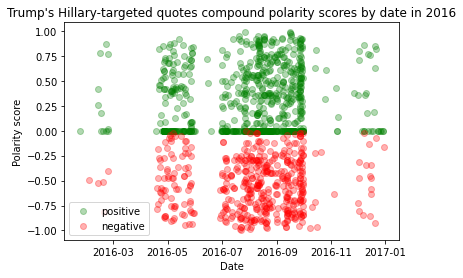

In [448]:
trump_on_clinton_pos = trump_on_clinton[trump_on_clinton['polarityScore'] >= 0]
trump_on_clinton_neg = trump_on_clinton[trump_on_clinton['polarityScore'] < 0]

plt.scatter(x=trump_on_clinton_pos['date'], y=trump_on_clinton_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_clinton_neg['date'], y=trump_on_clinton_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Hillary-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

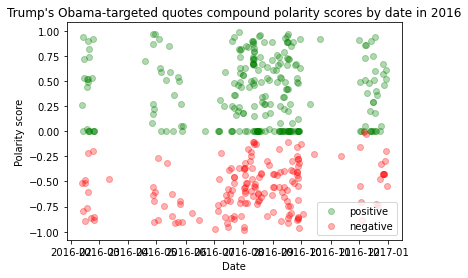

In [449]:
trump_on_obama_pos = trump_on_obama[trump_on_obama['polarityScore'] >= 0]
trump_on_obama_neg = trump_on_obama[trump_on_obama['polarityScore'] < 0]

plt.scatter(x=trump_on_obama_pos['date'], y=trump_on_obama_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_obama_neg['date'], y=trump_on_obama_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Obama-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

Perhaps a next step would be to compare this with a baseline ratio of positive/negative words. For instance, maybe on average people say 70% positive things and 30% negative. Knowing this could help compare results with Trump and Clinton.

### Pronoun analysis

A large part of analyzing someone's speech is not only about what they say, but how they say it. People reveal who they are through their own words. Now besides content words such as nouns, regular & action verbs, and modifiers (adjectives and adverbs), there is a separate class of words called style or function words that, on their own, do not signify anything.

However, it turns out these function words are very good at indicating the current emotion of the speaker as well as how they think since they are processed differently in the brain and their use follows a power law in most languages. For instance, when someone is depressed, they will use the pronoun "I" more frequently. There are also gender differences when it comes to function words. Women use more first-person words such as "I" or "we" whereas men prefer to use articles like "a" and "the".

How do these differences fare between Hillary Clinton and Donald Trump? Do they talk more about themselves with "I" or "me" or about others?

TODO: Pronoun use by target? Do on whole dataset!

In [450]:
#Counting number of most frequently used pronouns in the English language by candidate

freq_pronouns = ['it','I','you','he','they','we','she','who','them','me']
trump_pronouns_spc, clinton_pronouns_spc = [],[]
trump_I_count, clinton_I_count, trump_who_count, clinton_who_count = [],[],[],[]
trump_nb_pronouns, clinton_nb_pronouns, trump_spc_count, clinton_spc_count = 0,0,0,0

for k in freq_pronouns:
    for i in range(len(trump_df)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(k), trump_df['quotation'].iloc[i]))
        trump_nb_pronouns += count
        trump_spc_count += count
        if k == 'I':
            trump_I_count.append(count)
        if k == 'who':
            trump_who_count.append(count)
    trump_pronouns_spc.append(trump_spc_count)
    trump_spc_count = 0

for k in freq_pronouns:
    for i in range(len(clinton_df)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(k), clinton_df['quotation'].iloc[i]))
        clinton_nb_pronouns += count
        clinton_spc_count += count
        if k == 'I':
            clinton_I_count.append(count)
        if k == 'who':
            clinton_who_count.append(count)
    clinton_pronouns_spc.append(clinton_spc_count)
    clinton_spc_count = 0

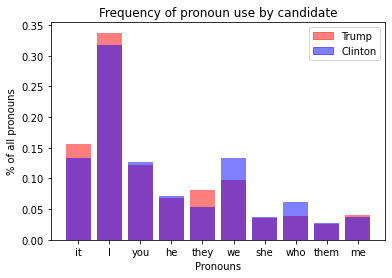

In [460]:
scaled_trump_pronouns = [x/trump_nb_pronouns for x in trump_pronouns_spc]
scaled_clinton_pronouns = [x/clinton_nb_pronouns for x in clinton_pronouns_spc]

plt.bar(freq_pronouns, scaled_trump_pronouns, color='red', alpha=0.5)
plt.bar(freq_pronouns, scaled_clinton_pronouns, color='blue', alpha=0.5)
plt.title('Frequency of pronoun use by candidate')

red_patch = mpatches.Patch(color='red', alpha=0.5, label='Trump')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Clinton')

plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Pronouns')
plt.ylabel('% of all pronouns')
plt.show()

In [ ]:
import plotly.express as px

pronouns = pd.DataFrame()
pronouns['Pronoun count'] = scaled_trump_pronouns
pronouns['Pronouns'] = freq_pronouns
fig = px.bar(pronouns, x='Pronouns', y='Pronoun count')
fig.show()

In [453]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=scaled_trump_pronouns,
    name='Trump pronoun count',
    marker_color='red'
))
fig.add_trace(go.Bar(
    x=freq_pronouns,
    y=scaled_clinton_pronouns,
    name='Clinton pronoun count',
    marker_color='blue'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

Another interesting finding relates to the social class differences in language patterns. People from higher social classes tend to use more articles and prepositions compared to their lower class counterparts which use more pronouns and auxiliary verbs. This difference is known to be statistically significant.

Does Donald Trump target the lower and middle classes better? The heartland of America? It certainly helped Trump in his case, since listeners feel closer to the speaker when the word "I" is used more often, even though political advisors usually suggest to use more "we" which unfortunately creates the opposite effect, such as during John Kerry's 2004 Presidential run. However, it is very likely that knowing this wouldn't have changed the outcome in 2004 nor in 2016. Language is a powerful reflection of a person's personality and character but does not change a person on its own.

This is in fact a counterintuitive finding as well since, as a man, Donald Trump would be statistically much more likely to use more articles and nouns and less likely to use pronouns than Hillary Clinton, his female adversary. Donald Trump's high social status also does not account for this pronoun use by the Republican candidate.

#### Plotting average sentiment in sentences with select pronouns

In [454]:
trump_sentiment_pronouns, clinton_sentiment_pronouns = [],[]

for i in freq_pronouns:
    temp_trump = dt_cleaned_sample[dt_cleaned_sample['quotation'].str.contains(i)]
    trump_sentiment_pronouns.append(temp_trump['polarityScore'].mean())
    temp_clinton = hc_cleaned_sample[hc_cleaned_sample['quotation'].str.contains(i)]
    clinton_sentiment_pronouns.append(temp_clinton['polarityScore'].mean())

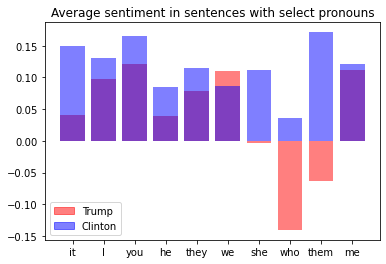

In [455]:
plt.bar(freq_pronouns, trump_sentiment_pronouns, color='red', alpha=0.5)
plt.bar(freq_pronouns, clinton_sentiment_pronouns, color='blue', alpha=0.5)
plt.title('Average sentiment in sentences with select pronouns')

red_patch = mpatches.Patch(color='red', alpha=0.5, label='Trump')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Clinton')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

#### Showing random negative Trump quote containing "who"

In [465]:
import numpy as np
import random
trump_who = np.array(trump_who_count)
trump_who_indices = trump_who.nonzero()

random_quote = random.randint(0, len(trump_who_indices[0]))
trump_df['quotation'].iloc[trump_who_indices[0][random_quote]]

"If I were totally presidential, I'd be one of the many people who are already out of the race,"

### "Crooked Hillary"?

Trump famously popularized the harsh phrase "Crooked Hillary" to denote the dishonesty that he perceived from his opponent. But was there some basis for this statement? It turns out, deception can also be captured by language to some degree. Most people, when telling the truth about an important situation, will use more often the pronoun "I" (single best predictor of a person's honesty --> QUOTE THE BOOK HERE) as well as more negative emotion. However, in our case, Clinton used both less "I" and less negative emotion than Trump for most pronouns. This gives some evidence for the validity of Trump's nickname for Clinton, cruel as it is.

In [457]:
distance_verbs = ['would','could','should']
trump_verbs_spc, clinton_verbs_spc = [],[]
trump_nb_verbs, clinton_nb_verbs, trump_verb_count, clinton_verb_count = 0,0,0,0

for k in distance_verbs:
    for i in range(len(trump_df)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(k), trump_df['quotation'].iloc[i]))
        trump_nb_verbs += count
        trump_verb_count += count
    trump_verbs_spc.append(trump_verb_count)
    trump_verb_count = 0

for k in distance_verbs:
    for i in range(len(clinton_df)):
        count = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(k), clinton_df['quotation'].iloc[i]))
        clinton_nb_verbs += count
        clinton_verb_count += count
    clinton_verbs_spc.append(clinton_verb_count)
    clinton_verb_count = 0

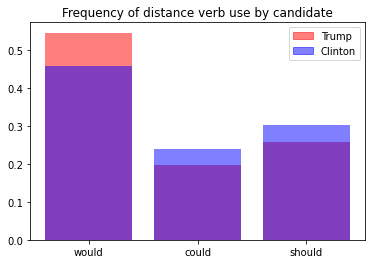

In [458]:
scaled_trump_verbs = [x/trump_nb_verbs for x in trump_verbs_spc]
scaled_clinton_verbs = [x/clinton_nb_verbs for x in clinton_verbs_spc]

plt.bar(distance_verbs, scaled_trump_verbs, color='red', alpha=0.5)
plt.bar(distance_verbs, scaled_clinton_verbs, color='blue', alpha=0.5)
plt.title('Frequency of distance verb use by candidate')

red_patch = mpatches.Patch(color='red', alpha=0.5, label='Trump')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Clinton')

plt.legend(handles=[red_patch, blue_patch])
plt.show()